Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.67MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/20], Loss: 0.06877724762787543
Epoch [2/20], Loss: 0.020353008868378594
Epoch [3/20], Loss: 0.012032365067555183
Epoch [4/20], Loss: 0.009911145521288849
Epoch [5/20], Loss: 0.009731235000302702
Epoch [6/20], Loss: 0.0023621207579197423
Epoch [7/20], Loss: 0.0007700121936602617
Epoch [8/20], Loss: 0.0011153745134540726
Epoch [9/20], Loss: 0.0023531318795225477
Epoch [10/20], Loss: 0.005271456576322796
Epoch [11/20], Loss: 0.009116634661724394
Epoch [12/20], Loss: 0.00995035750553132
Epoch [13/20], Loss: 0.008810998684485202
Epoch [14/20], Loss: 0.0019146308636608098
Epoch [15/20], Loss: 0.0006891569445624449
Epoch [16/20], Loss: 9.756102866368857e-05
Epoch [17/20], Loss: 2.548502142987941e-05
Epoch [18/20], Loss: 1.7199519695500653e-05
Epoch [19/20], Loss: 1.3595318258005554e-05
Epoch [20/20], Loss: 1.1312048280232481e-05
Accuracy on adversarial examples: 8.922232978380123%


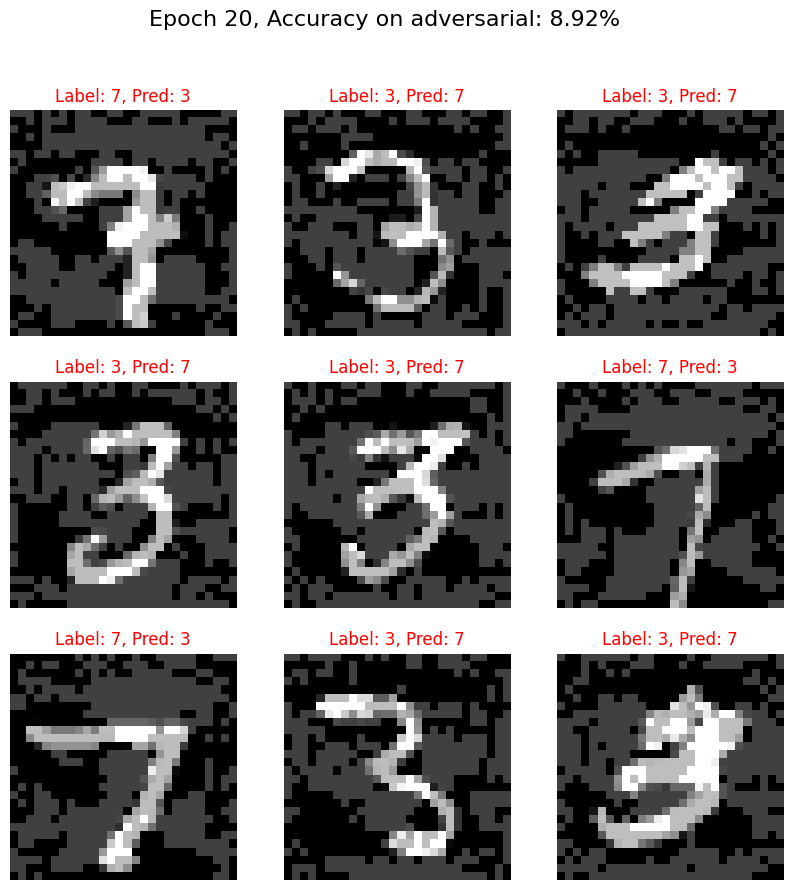

In [ ]:
# @title Bonne version, rnn simple avec epsilon = 0.25
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # Assurez-vous que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()



    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (réseau neuronal simple)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplatir l'image en vecteur
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = SimpleNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 0.07358967469400275
Epoch [2/20], Loss: 0.020343069238376685
Epoch [3/20], Loss: 0.013124803813176168
Epoch [4/20], Loss: 0.00859862804759125
Epoch [5/20], Loss: 0.0036138346894399407
Epoch [6/20], Loss: 0.005393081943536471
Epoch [7/20], Loss: 0.011707352818226739
Epoch [8/20], Loss: 0.004827631039786798
Epoch [9/20], Loss: 0.0030305578994152646
Epoch [10/20], Loss: 0.01029273313312344
Epoch [11/20], Loss: 0.003173496509616526
Epoch [12/20], Loss: 0.002074986879270817
Epoch [13/20], Loss: 0.000301811208818007
Epoch [14/20], Loss: 4.8857749666835e-05
Epoch [15/20], Loss: 1.7423418986530267e-05
Epoch [16/20], Loss: 1.3565195226668771e-05
Epoch [17/20], Loss: 1.11092872098584e-05
Epoch [18/20], Loss: 9.40438400213115e-06
Epoch [19/20], Loss: 8.214833856016968e-06
Epoch [20/20], Loss: 7.145616989638572e-06
Accuracy on adversarial examples: 4.170700225879316%


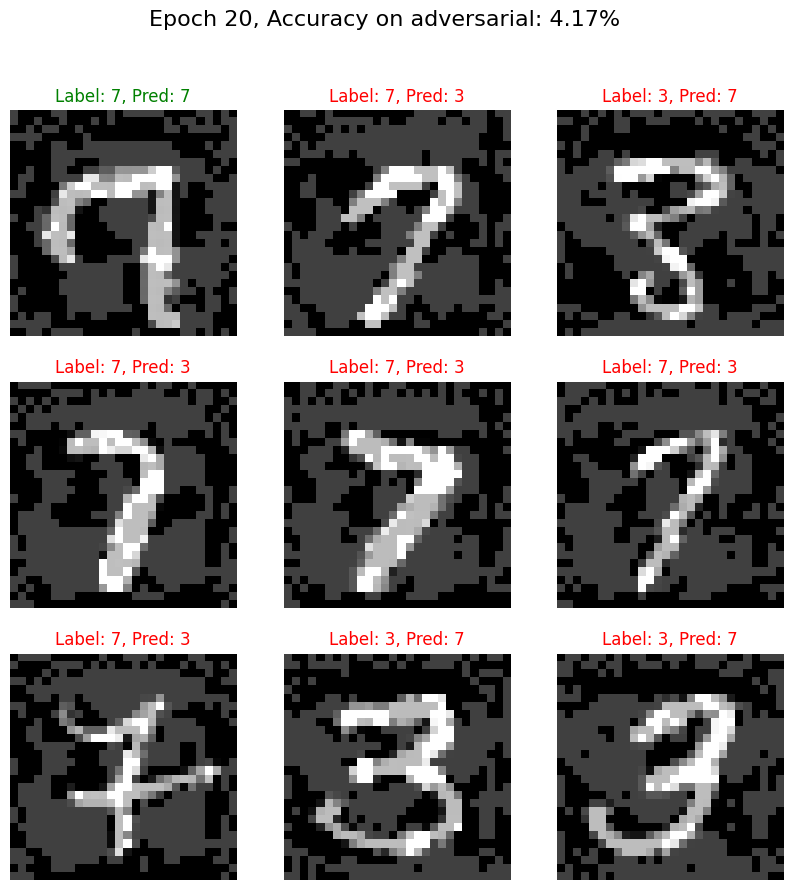

In [ ]:
# @title Bonne version, rnn deep avec epsilon = 0.25
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # Assurez-vous que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()



    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (réseau neuronal simple)
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = DeepNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


In [ ]:
# @title Partie juste au dessus du 6 : Maxout et L1 Weight Decay
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# Classe Maxout
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()
        self.num_pieces = num_pieces
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, self.num_pieces) # Reshape to (batch_size, out_features, num_pieces)

        # Get the max value along the num_pieces dimension
        return x.max(-1)[0]

# Classe du modèle (réseau profond avec maxout)
class DeepMaxoutNN(nn.Module):
    def __init__(self):
        super(DeepMaxoutNN, self).__init__()
        self.maxout1 = Maxout(28 * 28, 256, 4)  # Maxout avec 4 morceaux
        self.maxout2 = Maxout(256, 128, 4)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.maxout1(x)
        x = self.maxout2(x)
        x = self.fc(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10, l1_lambda=0.0):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            # Ajout de la régularisation \(L_1\) sur les poids de la première couche uniquement
            if l1_lambda > 0.0:
                l1_norm = torch.norm(model.maxout1.linear.weight, p=1)
                loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement
    l1_lambda = 0.001  # Coefficient de régularisation L1 (testez différentes valeurs)

    # Charger les données
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = DeepMaxoutNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales avec régularisation \(L_1\)
    train_on_normal_data(model, train_loader, optimizer, epochs, l1_lambda)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()



Epoch [1/20], Loss: 1.7678995107867055
Epoch [2/20], Loss: 1.1134581018968956
Epoch [3/20], Loss: 1.1258773416587986
Epoch [4/20], Loss: 1.13811232871616
Epoch [5/20], Loss: 20.013273882497217
Epoch [6/20], Loss: 4.0197752640419395
Epoch [7/20], Loss: 1.710153229457816
Epoch [8/20], Loss: 1.336252144317037
Epoch [9/20], Loss: 1.2117254899949144
Epoch [10/20], Loss: 1.1812423738007694
Epoch [11/20], Loss: 1.1947926989535695
Epoch [12/20], Loss: 1.1275780618805247
Epoch [13/20], Loss: 1.1984773394987756
Epoch [14/20], Loss: 1.0748417988880394
Epoch [15/20], Loss: 1.0694546115767096
Epoch [16/20], Loss: 1.0799991116695797
Epoch [17/20], Loss: 1.0848482549190521
Epoch [18/20], Loss: 1.1545481657244496
Epoch [19/20], Loss: 1.077918902807629
Epoch [20/20], Loss: 1.0925353218599694
Accuracy on adversarial examples: 14.270732494353018%


voir chatgpt 26/11 a 19:30
Régularisation avec methode FGSM, on train maintenant sur des données adversariale, alors qu'avant on trainait sur des données normales et testait sur des données adv

Epoch [1/20], Loss: 0.4098396000942004
Epoch [2/20], Loss: 0.19199239911953198
Epoch [3/20], Loss: 0.12760434270903623
Epoch [4/20], Loss: 0.10277823226276747
Epoch [5/20], Loss: 0.09049677365872356
Epoch [6/20], Loss: 0.07828731600617625
Epoch [7/20], Loss: 0.07159250343852129
Epoch [8/20], Loss: 0.06388826835804533
Epoch [9/20], Loss: 0.06346892036459188
Epoch [10/20], Loss: 0.053548774182719666
Epoch [11/20], Loss: 0.04912698057182517
Epoch [12/20], Loss: 0.051431526074704435
Epoch [13/20], Loss: 0.04416962731245559
Epoch [14/20], Loss: 0.04723819004630996
Epoch [15/20], Loss: 0.04413701623159739
Epoch [16/20], Loss: 0.043429013003220725
Epoch [17/20], Loss: 0.04240462011849681
Epoch [18/20], Loss: 0.043972146414105115
Epoch [19/20], Loss: 0.037172838637470895
Epoch [20/20], Loss: 0.037691555302782155
Accuracy on adversarial examples: 98.78186511777993%


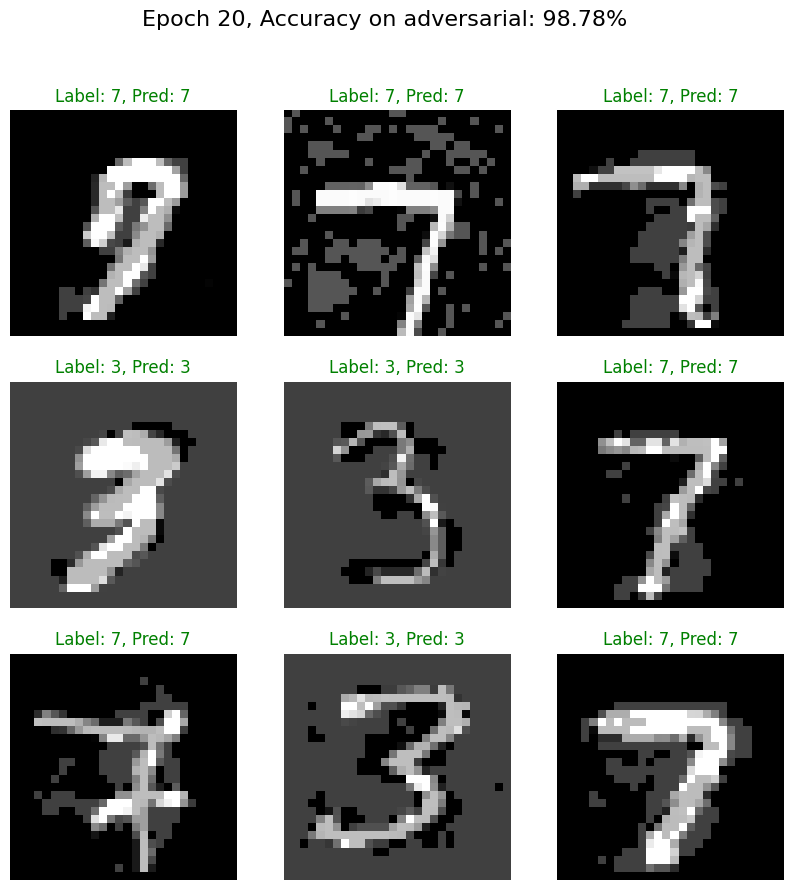

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # Assurez-vous que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Définir une unité Maxout
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_units):
        super(Maxout, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_units = num_units
        self.fc = nn.Linear(in_features, out_features * num_units)

    def forward(self, x):
        # Calculer la sortie de la couche Maxout
        x = self.fc(x)
        x = x.view(-1, self.out_features, self.num_units)
        return torch.max(x, dim=2)[0]  # Prendre le maximum sur les unités de Maxout

# Classe du modèle Maxout (réseau Maxout avec dropout)
class MaxoutNN(nn.Module):
    def __init__(self):
        super(MaxoutNN, self).__init__()
        self.fc1 = Maxout(28*28, 128, 2)  # 2 unités par neurone
        self.fc2 = Maxout(128, 10, 2)     # 2 unités par neurone
        self.dropout = nn.Dropout(0.5)    # Dropout avec un taux de 50%

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplatir l'image en vecteur
        x = self.fc1(x)
        x = self.dropout(x)  # Appliquer dropout
        x = self.fc2(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales avec adversarial training
def train_on_adversarial_data(model, train_loader, optimizer, epsilon, lambda_adversarial, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Obtenir les exemples adversariaux
            adversarial_images = FGSM(model, images, labels, epsilon)

            # Calculer la perte sur les images normales
            outputs = model(images)
            loss_normal = nn.CrossEntropyLoss()(outputs, labels)

            # Calculer la perte sur les images adversariales
            outputs_adv = model(adversarial_images)
            loss_adv = nn.CrossEntropyLoss()(outputs_adv, labels)

            # Perte combinée (avec lambda pour réguler l'importance des exemples adversariaux)
            loss = lambda_adversarial*loss_normal + (1-lambda_adversarial) * loss_adv
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0

    for images, labels in train_loader:
        # Assurez-vous que les images nécessitent des gradients avant FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    lambda_adversarial = 0.5  # Hyperparamètre pour la régularisation des exemples adversariaux
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = MaxoutNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner sur des données avec adversarial training
    train_on_adversarial_data(model, train_loader, optimizer, epsilon, lambda_adversarial, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


" We observed that we were not reaching zero error rate on adversarial examples on the training set.
 Wefixedthis problem by makingtwochanges. First, we made the model larger, using 1600 units per
 layer rather than the 240 used by the original maxout network for this problem"
 attteeeeeeeeeeention ca va etre tres long a tourner


Epoch [1/10], Loss: 0.3049410782255155
Epoch [2/10], Loss: 0.10835461263285623
Epoch [3/10], Loss: 0.07291254457134332
Epoch [4/10], Loss: 0.0694788861827752
Epoch [5/10], Loss: 0.05998980015103427
Epoch [6/10], Loss: 0.10639609050212101
Epoch [7/10], Loss: 0.07677761700301979
Epoch [8/10], Loss: 0.07630618583181747
Epoch [9/10], Loss: 0.06404934805278131
Epoch [10/10], Loss: 0.0514229340479528
Accuracy on adversarial examples: 97.44272345918039%
Confiance moyenne sur les exemples mal classifiés : 83.91%


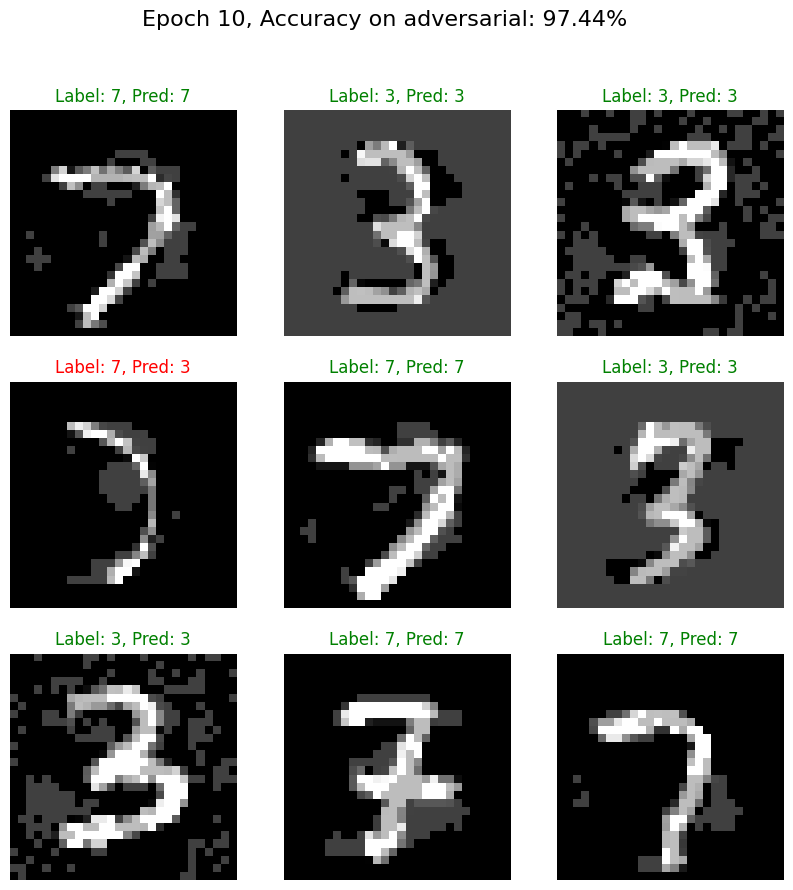

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Définir une unité Maxout
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_units):
        super(Maxout, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_units = num_units
        self.fc = nn.Linear(in_features, out_features * num_units)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.out_features, self.num_units)
        return torch.max(x, dim=2)[0]  # Prendre le maximum sur les unités de Maxout

# Classe du modèle Maxout (réseau Maxout agrandi)
class LargeMaxoutNN(nn.Module):
    def __init__(self):
        super(LargeMaxoutNN, self).__init__()
        self.fc1 = Maxout(28*28, 1600, 2)  # 1600 unités avec 2 activations maxout
        self.fc2 = Maxout(1600, 1600, 2)   # Deuxième couche avec 1600 unités
        self.fc3 = Maxout(1600, 10, 2)     # Couche de sortie avec 10 classes
        self.dropout = nn.Dropout(0.5)    # Dropout avec un taux de 50%

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplatir l'image en vecteur
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales avec adversarial training
def train_on_adversarial_data(model, train_loader, optimizer, epsilon, lambda_adversarial, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Obtenir les exemples adversariaux
            adversarial_images = FGSM(model, images, labels, epsilon)

            # Calculer la perte sur les images normales
            outputs = model(images)
            loss_normal = nn.CrossEntropyLoss()(outputs, labels)

            # Calculer la perte sur les images adversariales
            outputs_adv = model(adversarial_images)
            loss_adv = nn.CrossEntropyLoss()(outputs_adv, labels)

            # Perte combinée
            loss = loss_normal + lambda_adversarial * loss_adv
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()

    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Calcul de la confiance moyenne sur les erreurs
def analyze_confidence(model, data_loader, epsilon):
    model.eval()

    total_confidence = 0
    total_misclassified = 0

    for images, labels in data_loader:
        # Générer des exemples adversariaux
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Prédictions
        outputs = model(adversarial_images)
        probabilities = nn.Softmax(dim=1)(outputs)  # Calcul des probabilités via softmax
        confidence, predictions = torch.max(probabilities, 1)  # Confiance et classe prédite

        # Identifier les erreurs de classification
        misclassified = (predictions != labels)
        total_confidence += confidence[misclassified].sum().item()  # Somme des confiances sur les erreurs
        total_misclassified += misclassified.sum().item()  # Nombre total d'erreurs

    if total_misclassified > 0:
        avg_confidence = total_confidence / total_misclassified
    else:
        avg_confidence = 0  # Cas où il n'y a pas d'erreurs

    print(f"Confiance moyenne sur les exemples mal classifiés : {avg_confidence * 100:.2f}%")
    return avg_confidence

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    lambda_adversarial = 0.5  # Hyperparamètre pour la régularisation des exemples adversariaux
    epochs = 10 # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = LargeMaxoutNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner sur des données avec adversarial training
    train_on_adversarial_data(model, train_loader, optimizer, epsilon, lambda_adversarial, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Calculer et afficher la confiance moyenne
    avg_confidence = analyze_confidence(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Visualisation des poids pour des modeles entraines adversarialement et non adversarialement :

Entraînement sur données normales...
Epoch [1/2], Loss: 0.0957
Epoch [2/2], Loss: 0.0364

Entraînement sur données adversariales...
Epoch [1/2], Loss: 0.4848
Epoch [2/2], Loss: 0.1466

Poids du modèle normal pour la classe 3 :


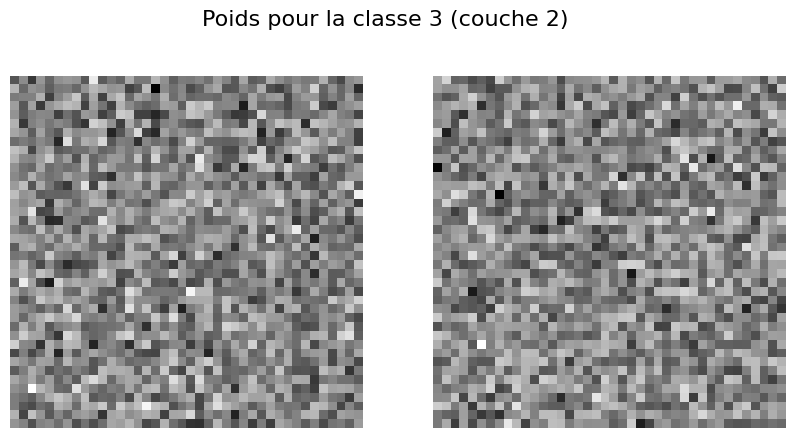


Poids du modèle normal pour la classe 7 :


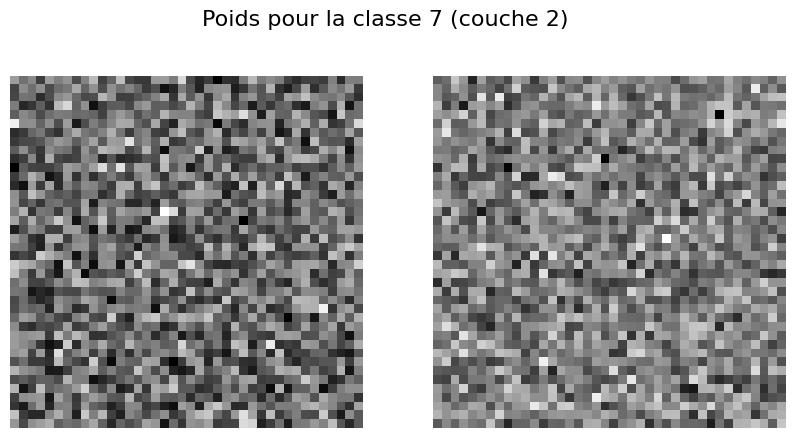


Poids du modèle adversarial pour la classe 3 :


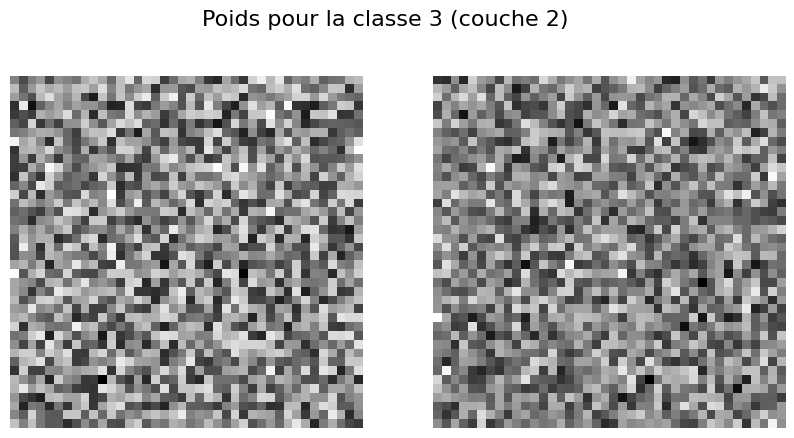


Poids du modèle adversarial pour la classe 7 :


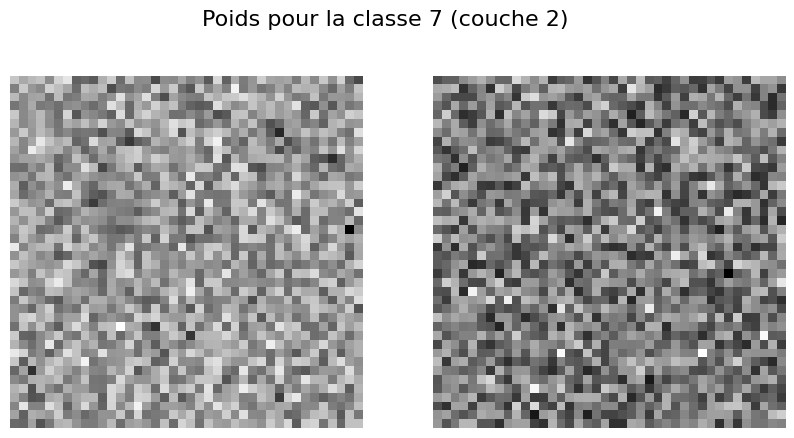

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset

# Définir une unité Maxout
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_units):
        super(Maxout, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_units = num_units
        self.fc = nn.Linear(in_features, out_features * num_units)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.out_features, self.num_units)
        return torch.max(x, dim=2)[0]  # Prendre le maximum sur les unités de Maxout

# Classe du modèle Maxout (réseau Maxout agrandi)
class LargeMaxoutNN(nn.Module):
    def __init__(self):
        super(LargeMaxoutNN, self).__init__()
        self.fc1 = Maxout(28*28, 1600, 2)
        self.fc2 = Maxout(1600, 1600, 2)
        self.fc3 = Maxout(1600, 10, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Définir une attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    # Calcul de la perte
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Générer les perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adv_images = images + perturbation
    adv_images = torch.clamp(adv_images, 0, 1)  # Clipper les images entre [0, 1]
    return adv_images

# Entraîner un modèle sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Entraîner un modèle sur des données adversariales
def train_on_adversarial_data(model, train_loader, optimizer, epsilon, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            # Générer des exemples adversariaux
            adv_images = FGSM(model, images, labels, epsilon)

            outputs = model(adv_images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Visualisation des poids par classe
def plot_class_specific_weights(model, class_idx, layer_idx=2):
    # Extraire les poids de la couche spécifiée
    if layer_idx == 1:
        weights = model.fc1.fc.weight.detach().cpu().numpy()
    elif layer_idx == 2:
        weights = model.fc2.fc.weight.detach().cpu().numpy()
    else:
        raise ValueError("Seules les couches disponibles sont 'fc1' et 'fc2'.")

    # Filtrer les poids associés à la classe (Maxout spécifique)
    class_weights = weights[class_idx * 2:(class_idx + 1) * 2]

    # Affichage des poids sous forme d'images
    plt.figure(figsize=(10, 5))
    for i, weight in enumerate(class_weights):
        plt.subplot(1, len(class_weights), i + 1)
        plt.imshow(weight.reshape(40, 40), cmap='gray')  # Ajuster selon les dimensions
        plt.axis('off')
    plt.suptitle(f"Poids pour la classe {class_idx} (couche {layer_idx})", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.3
    epochs = 2

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser les modèles
    model_normal = LargeMaxoutNN()
    model_adversarial = LargeMaxoutNN()

    optimizer_normal = optim.Adam(model_normal.parameters(), lr=0.001)
    optimizer_adversarial = optim.Adam(model_adversarial.parameters(), lr=0.001)

    # Entraîner les modèles
    print("Entraînement sur données normales...")
    train_on_normal_data(model_normal, train_loader, optimizer_normal, epochs)

    print("\nEntraînement sur données adversariales...")
    train_on_adversarial_data(model_adversarial, train_loader, optimizer_adversarial, epsilon, epochs)

    # Visualiser les poids pour les classes 3 et 7
    print("\nPoids du modèle normal pour la classe 3 :")
    plot_class_specific_weights(model_normal, class_idx=3, layer_idx=2)

    print("\nPoids du modèle normal pour la classe 7 :")
    plot_class_specific_weights(model_normal, class_idx=7, layer_idx=2)

    print("\nPoids du modèle adversarial pour la classe 3 :")
    plot_class_specific_weights(model_adversarial, class_idx=3, layer_idx=2)

    print("\nPoids du modèle adversarial pour la classe 7 :")
    plot_class_specific_weights(model_adversarial, class_idx=7, layer_idx=2)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Training on normal data...
Epoch [1/10], Loss: 0.6931990111611553
Epoch [2/10], Loss: 0.6931268111946657
Epoch [3/10], Loss: 0.6931228106169357
Epoch [4/10], Loss: 0.69314050336474
Epoch [5/10], Loss: 0.6931168237297806
Epoch [6/10], Loss: 0.6931502004874122
Epoch [7/10], Loss: 0.6931202946249971
Epoch [8/10], Loss: 0.6931350907099616
Epoch [9/10], Loss: 0.6931477591548998
Epoch [10/10], Loss: 0.6931282484654299

Visualizing RBF centers...


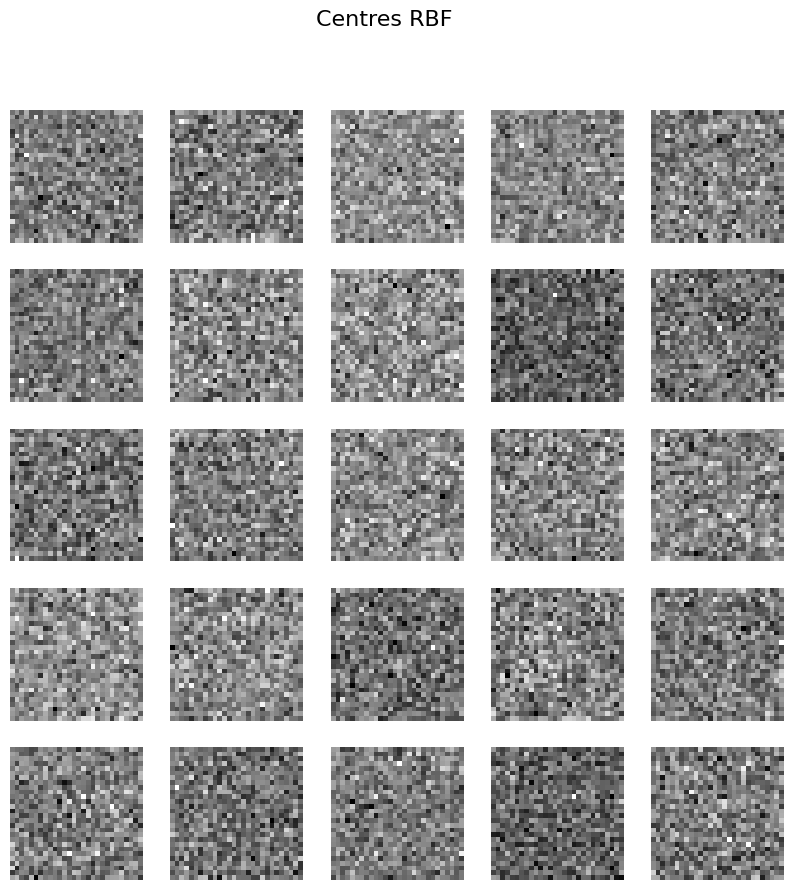


Evaluating on clean data...
Accuracy: 50.54%
Average Confidence: 50.25%

Evaluating on adversarial data...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [7]:
#partie 7 :
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# Charger les données MNIST (seulement les 3 et 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# RBF Layer (fonction radiale de base)
class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, sigma=None):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centers = nn.Parameter(torch.randn(out_features, in_features))  # Centres des RBF
        self.sigma = sigma if sigma else nn.Parameter(torch.ones(1))  # Largeur des RBF

    def forward(self, x):
        # Calculer la distance euclidienne au carré entre les données et les centres
        dists = torch.cdist(x, self.centers) ** 2
        # Appliquer la fonction radiale de base (gaussienne)
        return torch.exp(-dists / (2 * self.sigma ** 2))

# Réseau RBF complet
class RBFNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RBFNetwork, self).__init__()
        self.rbf = RBFLayer(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rbf_out = self.rbf(x)
        return self.fc(rbf_out)

# Générer des données adversariales avec FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = torch.clamp(images + perturbation, 0, 1)  # Clipper entre [0, 1]
    return adversarial_images

# Entraîner le modèle
# Entraîner le modèle
def train_model(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            # Aplatir les images (28x28 -> 784)
            images = images.view(images.size(0), -1)

            # Fix: Change the way labels are transformed
            # Original: labels = labels - 3
            # The condition below maps 3 to 0 and 7 to 1
            labels = torch.where(labels == 3, 0, 1)


            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Évaluer la confiance
# Évaluer la confiance
def evaluate_confidence(model, loader, epsilon=None):
    model.eval()
    correct = 0
    total = 0
    confidences = []

    with torch.no_grad():
        for images, labels in loader:
            original_images = images.clone()

            # Aplatir les images
            images = images.view(images.size(0), -1)

            # Fix: Use a conditional statement to assign labels
            # This maps 3 to 0 and 7 to 1 for binary classification
            labels = torch.where(labels == 3, 0, 1)

            if epsilon:
                # Fix: Ensure images require gradients before FGSM
                images = images.clone().detach().requires_grad_(True) #  This line is changed to ensure gradient is activated for images
                # Générer des exemples adversariaux
                images = FGSM(model, images, labels, epsilon)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            predicted = outputs.argmax(dim=1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            confidences.extend(probs.max(dim=1).values.tolist())

    accuracy = correct / total
    avg_confidence = np.mean(confidences)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Average Confidence: {avg_confidence * 100:.2f}%")
    return accuracy, avg_confidence

# Visualisation des poids des centres RBF
def visualize_rbf_centers(rbf_layer):
    centers = rbf_layer.centers.detach().cpu().numpy()
    num_centers = min(25, centers.shape[0])  # Limiter à 25 centres à afficher

    plt.figure(figsize=(10, 10))
    for i in range(num_centers):
        plt.subplot(5, 5, i + 1)
        plt.imshow(centers[i].reshape(28, 28), cmap='gray')  # Reshape en 28x28 pour visualiser comme une image
        plt.axis('off')
    plt.suptitle("Centres RBF", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Charger les données
    train_loader = load_data()

    # Initialiser le modèle, l'optimizer, et les hyperparamètres
    input_dim = 28 * 28
    hidden_dim = 100  # Nombre de centres RBF
    output_dim = 2  # Classification binaire (3 ou 7)

    model = RBFNetwork(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner sur des données normales
    print("Training on normal data...")
    train_model(model, train_loader, optimizer, epochs=10)

    # Visualiser les centres RBF
    print("\nVisualizing RBF centers...")
    visualize_rbf_centers(model.rbf)

    # Évaluer sur des données propres
    print("\nEvaluating on clean data...")
    evaluate_confidence(model, train_loader)

    # Évaluer sur des données adversariales
    print("\nEvaluating on adversarial data...")
    evaluate_confidence(model, train_loader, epsilon=0.3)

if __name__ == "__main__":
    main()
